In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Задание 1

Напишите функцию, которая классифицирует фильмы из материалов занятия по следующим правилам:  
- оценка 2 и меньше - низкий рейтинг
- оценка 4 и меньше - средний рейтинг
- оценка 4.5 и 5 - высокий рейтинг

Результат классификации запишите в столбец class

In [2]:
movie_data = pd.read_csv('ml-latest-small/movies.csv')

In [3]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
scores_data = pd.read_csv('ml-latest-small/ratings.csv')

In [5]:
scores_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Посчитаем средний рейтинг по каждому фильму на основе оценок пользователей

In [6]:
mean_film_scores = scores_data.groupby('movieId')['rating'].mean().reset_index()

In [7]:
mean_film_scores.head()

,movieId,rating
0,1,3.872470
1,2,3.401869
2,3,3.161017
3,4,2.384615
4,5,3.267857


Для каждой строки фильма определим его рейтинг по средней оценке

In [8]:
def film_rating(movieId, mean_film_scores):
    film_score_data = mean_film_scores[mean_film_scores['movieId'] == movieId] # поиск средней оценки в списке средних оценок
    if film_score_data.rating.empty: # обработка ситуации, если фильму не было выставлено ни одной оценки
        return 'doesn\'t have scores'
    else:
        film_score = film_score_data.rating.iloc[0]
        if film_score <= 2:
            return 'low rating'
        elif film_score <= 4:
            return 'average rating'
        elif film_score >= 4.5 and film_score <= 5:
            return 'high rating'
        else: # обработка ситуации, когда средняя оценка фильма между 4 и 4.5
            return 'unknown rating'   

In [9]:
movie_data['rating'] = movie_data['movieId'].apply(film_rating, mean_film_scores = mean_film_scores)

In [10]:
movie_data.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,average rating
1,2,Jumanji (1995),Adventure|Children|Fantasy,average rating
2,3,Grumpier Old Men (1995),Comedy|Romance,average rating
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,average rating
4,5,Father of the Bride Part II (1995),Comedy,average rating


## Задание 2

Используем файл keywords.csv.

Необходимо написать гео-классификатор, который каждой строке сможет выставить географическую принадлежность определенному региону. Т. е. если поисковый запрос содержит название города региона, то в столбце ‘region’ пишется название этого региона. Если поисковый запрос не содержит названия города, то ставим ‘undefined’.

Правила распределения по регионам Центр, Северо-Запад и Дальний Восток:

```
geo_data = {

'Центр': ['москва', 'тула', 'ярославль'],

'Северо-Запад': ['петербург', 'псков', 'мурманск'],

'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']
}
```

In [11]:
geo_data = {
'Центр': ['москва', 'тула', 'ярославль'],
'Северо-Запад': ['петербург', 'псков', 'мурманск'],
'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']
}

In [12]:
keywords_data = pd.read_csv('ml-latest-small/keywords.csv')

In [13]:
keywords_data

,keyword,shows
0,вк,64292779
1,одноклассники,63810309
2,порно,41747114
3,ютуб,39995567
4,вконтакте,21014195
...,...,...
99995,эльдорадо старый оскол,3705
99996,frigate для firefox,3630
99997,укрсиб,3630
99998,погода в ялте на неделю,3688


In [14]:
def define_region(keyword, geo_data):
    for region in geo_data.keys():
        for city in geo_data[region]:
            if city in keyword:
                return region
    return 'undefined'

In [15]:
keywords_data['region'] = keywords_data['keyword'].apply(define_region, geo_data = geo_data)

In [16]:
keywords_data[keywords_data['region'] != 'undefined'].head()

,keyword,shows,region
127,авито москва,979292,Центр
370,авито ру санкт петербург,425134,Северо-Запад
564,погода в санкт петербурге,292489,Северо-Запад
849,авито ярославль,209581,Центр
1063,фарпост владивосток,176951,Дальний Восток


## Задание 3

Есть мнение, что “раньше снимали настоящее кино, не то что сейчас”. Ваша задача проверить это утверждение, используя файлы с рейтингами фильмов из прошлого домашнего занятия (файл movies.csv и ratings.csv из базы https://grouplens.org/datasets/movielens). Т. е. проверить верно ли, что с ростом года выпуска фильма его средний рейтинг становится ниже.

При этом мы не будем затрагивать субьективные факторы выставления этих рейтингов, а пройдемся по следующему алгоритму:

1. В переменную years запишите список из всех годов с 1950 по 2010.

2. Напишите функцию production_year, которая каждой строке из названия фильма выставляет год выпуска. Не все названия фильмов содержат год выпуска в одинаковом формате, поэтому используйте следующий алгоритм:

    - для каждой строки пройдите по всем годам списка years
    - если номер года присутствует в названии фильма, то функция возвращает этот год как год выпуска
    - если ни один из номеров года списка years не встретился в названии фильма, то возвращается 1900 год

3. Запишите год выпуска фильма по алгоритму пункта 2 в новый столбец ‘year’

4. Посчитайте средний рейтинг всех фильмов для каждого значения столбца ‘year’ и отсортируйте результат по убыванию рейтинга

Определение года производства

In [17]:
years = list(range(1950, 2011))

In [18]:
def production_year(title, years):
    for year in years:
        if str(year) in title:
            return year
    return 1900       

In [19]:
movie_data['year'] = movie_data['title'].apply(production_year, years = years)

Определение числового показателя рейтинга фильма

In [20]:
def film_rating_numeral(movieId, mean_film_scores):
    film_score_data = mean_film_scores[mean_film_scores['movieId'] == movieId] # поиск средней оценки в списке средних оценок
    if film_score_data.rating.empty: # обработка ситуации, если фильму не было выставлено ни одной оценки
        return -1
    else:
        return film_score_data.rating.iloc[0]        

In [21]:
movie_data['rating_numeral'] = movie_data['movieId'].apply(film_rating_numeral, mean_film_scores = mean_film_scores)

In [22]:
movie_data.head()

,movieId,title,genres,rating,year,rating_numeral
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,average rating,1995,3.872470
1,2,Jumanji (1995),Adventure|Children|Fantasy,average rating,1995,3.401869
2,3,Grumpier Old Men (1995),Comedy|Romance,average rating,1995,3.161017
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,average rating,1995,2.384615
4,5,Father of the Bride Part II (1995),Comedy,average rating,1995,3.267857


Определение средних оценок за каждый год. Не учитываются фильмы, которым не было выставлено ни одной оценки и фильмы, год выпуска которых неизвестен

In [23]:
avg_rating_by_year = movie_data[(movie_data['rating'] != -1) & (movie_data['year'] != 1900)].groupby('year')['rating_numeral'].mean()

In [28]:
avg_rating_by_year.sort_values()

year
2001    3.133080
2003    3.136627
1990    3.166759
2000    3.179426
1997    3.183169
          ...   
1972    3.585295
1953    3.607243
1973    3.688212
1962    3.772962
1951    3.906653
Name: rating_numeral, Length: 61, dtype: float64

Построим график для наглядности

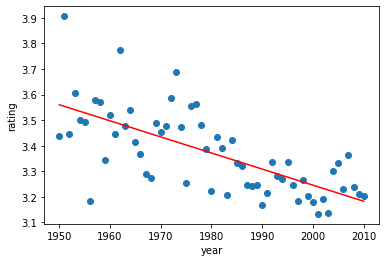

In [27]:
x = avg_rating_by_year.index
y = avg_rating_by_year.values
plt.scatter(x, y) # построение графика оценок по каждому году

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r') # построение линии тренда по данным рейтинга фильмов

plt.xlabel('year')
plt.ylabel('rating');

Как видно, чем соременее фильм (чем больше год его производства), тем ниже рейтинг фильма. Однако у ряда фильмов старых годов нет оценок и это может вносить погрешность в результат исследования.